# **HAND（Height Above Nearest Drainage）を算出するプログラム**

## **入力データ(dataというフォルダを作成してその中に格納)**
- **流向データ（tif）**
- **累積流量を抽出したデータ（tif）**
- **標高データ（tif）**

## **出力データ(outputというフォルダを作成してその中に格納)**
- **handデータ（tif）**
---

## **算出する手順**

### **Step 1: 依存するライブラリをダウングレードする**

まずは、NumPyなどの依存するライブラリをダウングレードします。具体的にはNumPyのバージョンを1.24以下に設定します。

#### **コード**

\`\`\`bash
conda install 'numpy<=1.24'
\`\`\`

---

### **Step 2: ダウングレードした環境でプログラムを実行する**

ダウングレードが完了したら、`.ipynb`か`.py`ファイルを実行します。どちらの形式でも好きな方を使用してください。

---


### Dijkstraのアルゴリズムの詳細

このアルゴリズムにおけるDijkstraのアルゴリズムは、優先度キュー（`pq`）を使用して最短距離を効率的に求めます。具体的な手順は以下の通りです。

1. **優先度キューの取り出し(セルの計算する優先順番みたいなもの)**:
    - 優先度キュー（`pq`）から最も「フロー距離」が短いセル（`ci`, `cj`）とその距離（`current_distance`）を取り出す。

2. **近傍セルの更新**:
    - 取り出したセル（`ci`, `cj`）に隣接するセル（`ni`, `nj`）に対して以下を行う。
        1. 新しい距離（`new_distance`）を計算。この際、標高（`next_elevation`と`current_elevation`）も考慮する。
        2. 計算した新しい距離が現在の「フロー距離」（`flow_distance[ni, nj]`）よりも短い場合は、
            - `flow_distance[ni, nj]`を`new_distance`で更新。
            - 更新したセル（`ni`, `nj`）と新しい距離（`new_distance`）を優先度キューに追加。


この手順を優先度キューが空になるまで繰り返します。


In [13]:
from osgeo import gdal
import numpy as np
from numba import jit, float64, int64
import heapq
import rasterio
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Read raster data
flow_ds = gdal.Open("data/waterdirection.tif")#流向データの場所（パス）を指定
dem_ds = gdal.Open("data/umetatedem.tif")#標高データの場所(パス)を指定
river_ds = gdal.Open("data/suikeisize.tif")#水系サイズを抽出したファイルの場所(パス)を指定

In [14]:
@jit
def calculate_flow_distance(flow_direction, dem, river_100):
    rows, cols = flow_direction.shape
    flow_distance = np.full((rows, cols), np.inf, dtype=np.float64)

    pq = []

    for i in range(rows):
        for j in range(cols):
            if river_100[i, j] == 1:
                flow_distance[i, j] = 0
                heapq.heappush(pq, (0, i, j))

    # Dijkstra's algorithm
    directions = [
        (-2, -1), (-2, 0), (-2, 1), (-2, 2),
        (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2),
        (0, -2),           (0, 0),           (0, 2),
        (1, -2),  (1, -1),  (1, 0),  (1, 1),  (1, 2),
        (2, -1),  (2, 0),   (2, 1),  (2, 2)
    ]

    
    while len(pq) > 0:
        current_distance, ci, cj = heapq.heappop(pq)

        for dx, dy in directions:
            ni, nj = ci + dx, cj + dy

            if 0 <= ni < rows and 0 <= nj < cols:
                next_elevation = dem[ni, nj]
                current_elevation = dem[ci, cj]
                
                slope_distance = np.sqrt(dx**2 + dy**2 + (next_elevation - current_elevation)**2)
                new_distance = current_distance + slope_distance

                if new_distance < flow_distance[ni, nj]:
                    flow_distance[ni, nj] = new_distance
                    heapq.heappush(pq, (new_distance, ni, nj))

    return flow_distance


flow_direction = np.array(flow_ds.GetRasterBand(1).ReadAsArray(), dtype=np.float64)
dem = np.array(dem_ds.GetRasterBand(1).ReadAsArray(), dtype=np.float64)
river_100 = np.array(river_ds.GetRasterBand(1).ReadAsArray(), dtype=np.int64)

# Step 2: Calculate flow distance
flow_distance = calculate_flow_distance(flow_direction, dem, river_100)


/var/folders/j0/nflgpwr54cj4kxg69281s2zw0000gq/T/ipykernel_97396/138956151.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def calculate_flow_distance(flow_direction, dem, river_100):
/var/folders/j0/nflgpwr54cj4kxg69281s2zw0000gq/T/ipykernel_97396/138956151.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "calculate_flow_distance" failed type inference due to: Type of variable 'ci' cannot be determined, operation: $144unpack_sequence.5, location: /var/folders/j0/nflgpwr54cj4kxg69281s2zw0000gq/T/ipykernel_97396/138956151.py (25)

File "../../../../../../../var/folders/j0/nflgpwr54cj4kxg69281s2zw0000gq/T/ipykernel_

In [24]:
import os
if not os.path.exists("output"):
    os.makedirs("output")
output_ds = gdal.GetDriverByName('GTiff').Create("output/flow_distance.tif", flow_direction.shape[1], flow_direction.shape[0], 1, gdal.GDT_Float32)
if output_ds is None:
    print("Could not create output dataset. Check the directory and write permissions.")
else:
    output_ds.GetRasterBand(1).WriteArray(flow_distance)
    output_ds.SetProjection(flow_ds.GetProjection())
    output_ds.SetGeoTransform(flow_ds.GetGeoTransform())
    output_ds = None  # Close file


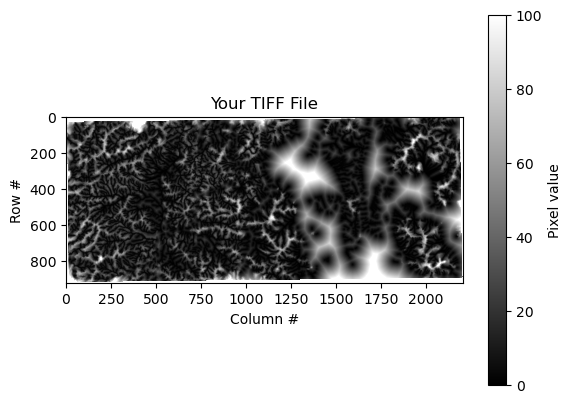

In [25]:
# TIFFファイルを読み込む
with rasterio.open("output/flow_distance.tif") as src:
    # バンド1のデータを読み込む
    image = src.read(1)

# データを図示する
im = plt.imshow(image, cmap="gray", vmax=100)  # vmaxでカラーバーの上限を100に設定
cbar = plt.colorbar(im, label="Pixel value")
plt.title("Your TIFF File")
plt.xlabel("Column #")
plt.ylabel("Row #")
plt.show()